# 回帰結合型のニューラルネットワーク（LSTM）による電力予測
---

## 目的
Long Short-Term Memory (LSTM) を用いて，電力予測の実験を行なう．


## 対応するチャプター
* 10.2: 回帰結合型ネットワークにおける勾配計算（BPTT）
* 10.10.1: LSTM
* 10.11: 勾配のクリッピング


## モジュールのインポート
プログラムの実行に必要なモジュールをインポートします．

In [10]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## データのダウンロード
プログラムの動作に必要なデータをダウンロードし，zipファイルを解凍します．

In [4]:
!wget -q http://www.mprg.cs.chubu.ac.jp/tutorial/ML_Lecture/SOLAR/data.zip -O data.zip
!unzip -q -o data.zip
!ls -R ./data

./data:
test  train

./data/test:
BEMS_RNN_test_data.npy	BEMS_RNN_test_labels.npy

./data/train:
BEMS_RNN_train_data.npy  BEMS_RNN_train_labels.npy


## データの読み込み
読み込んだデータを変換します．
ここで，delayは何時刻先の電力値を教師信号にするかを決定するためのパラメータです．
delay=1と設定した場合，ネットワークへ入力したデータの1時刻先の電力が正解ラベルとなります．

データのサイズを確認します．
ネットワークへの入力データサイズは34となっており，時刻や曜日などの情報を表現したデータとなっています，出力の値は対応する電力値の1つとなっています．

In [11]:
# データの読み込み
train_x = np.load('./data/train/BEMS_RNN_train_data.npy')
train_y = np.load('./data/train/BEMS_RNN_train_labels.npy')
test_x  = np.load('./data/test/BEMS_RNN_test_data.npy')
test_y = np.load('./data/test/BEMS_RNN_test_labels.npy')

# 0~1に収まるように正規化
train_x = (train_x - (-0.04)) / (1.3 - (-0.04))
train_y = (train_y - (-0.04)) / (1.3 - (-0.04))
test_x = (test_x - (-0.04)) / (1.3 - (-0.04))
test_y = (test_y - (-0.04)) / (1.3 - (-0.04))

# 数時刻先の電力が正解データになるように変換
delay = 1
train_x = np.asarray(train_x[ : -delay])
train_y = np.asarray(train_y[delay : ])
test_x = np.asarray(test_x[ : -delay])
test_y = np.asarray(test_y[delay : ])

# データのサイズ確認
train_y = train_y.reshape(len(train_y), 1)
test_y = test_y.reshape(len(test_y), 1)
print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

(49999, 34) (49999, 1)
(9999, 34) (9999, 1)


## ネットワークモデルの定義
次にネットワーク（LSTM）を定義します．

まずはじめに，ネットワークの定義に必要な関数を定義します．

In [14]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_grad(x):
#     return (1.0 - sigmoid(x)) * sigmoid(x)
    return (1.0 - x) * x

def tanh(x):
    return np.tanh(x)

def tanh_grad(x):
#     return 1.0 - np.tanh(x) * np.tanh(x)
    return 1.0 - x**2

def fc(x, w, b):
    return np.dot(w, x) + b

def fc_grad(dout, x, w, b):
    dx = np.dot(dout, w.T)
    d_w = np.dot(x.T, dout)
    d_b = np.sum(dout, axis=0)
    return dx, d_w, d_b

def mean_squared_error(pred, true):
    return np.sum(np.power(pred - true, 2))

次に，上で定義した関数を用いてネットワークを定義します．
ここでは，LSTM層，出力層から構成されるネットワークとします．

入力層と中間層，出力層のユニット数は引数として与え，それぞれ`n_input`，`n_hidden`, `n_out`とします．
そして，`__init__`関数を用いて，ネットワークのパラメータを初期化します．
下記のプログラムのうち，`w_i`から`b_o`はLSTMが持つパラメータを表しています．
`w`と`b`はそれぞれ出力層の重みとバイアスを表しています．
重みは`randn`関数で，標準正規分布に従った乱数で生成した値を保有する配列を生成します．
バイアスは`zeros`関数を用いて，要素が全て0の配列を生成します．

そして，`forward`関数で，データを入力して結果を出力するための演算を定義します．

次に，`backward`関数ではパラメータの更新量を計算します．
まず，ネットワークの出力結果と教師ラベルから，誤差`dy`を算出します．
この時，教師ラベルをone-hotベクトルへ変換し，各ユニットの出力との差を取ることで，`dy`を計算しています．
その後，連鎖律に基づいて，出力層から順番に勾配を計算していきます．
このとき，パラメータの更新量を`self.grads`へ保存しておきます．
また，LSTMでは時刻間で隠れ層とセル状態に対する勾配を伝播する必要があるため，
`backward`の引数として，1時刻先からの勾配情報を受け取り，前の時刻へ渡す勾配情報を返すようにしています．

最後に`update_parameters`関数で，更新量をもとにパラメータの更新を行います．

また，各時刻で求めた勾配を累積する必要があるため，`clear_grads`関数で，各パラメータの勾配情報を初期化する関数を定義し，学習時に使用します．

`clip_gradients`関数は，獲得した勾配を指定した範囲に収める関数です．
LSTMでは，各時刻の勾配を累積するため，勾配量が大きくなり勾配消失や爆発が起きる可能性があります．
ここでは，指定した範囲内に勾配を調整し，パラメータを更新することで，消失や爆発を抑制します．

In [1]:
class LSTM:
    
    def __init__(self, n_input, n_hidden, n_out, w_std=0.01):
        self.n_hidden = n_hidden
        
        # LSTM params
        self.w_i = np.random.randn(n_input, n_hidden) * w_std
        self.u_i = np.random.randn(n_hidden, n_hidden) * w_std
        self.b_i = np.zeros(n_hidden)
        
        self.w_f = np.random.randn(n_input, n_hidden) * w_std
        self.u_f = np.random.randn(n_hidden, n_hidden) * w_std
        self.b_f = np.zeros(n_hidden)
        
        self.w_c = np.random.randn(n_input, n_hidden) * w_std
        self.u_c = np.random.randn(n_hidden, n_hidden) * w_std
        self.b_c = np.zeros(n_hidden)
        
        self.w_o = np.random.randn(n_input, n_hidden) * w_std
        self.u_o = np.random.randn(n_hidden, n_hidden) * w_std
        self.b_o = np.zeros(n_hidden)
        
        # output layer
        self.w = np.random.randn(n_hidden, n_out) * w_std
        self.b = np.zeros(n_out)

        self.grads = {}
        self.clear_grads()
        
    def forward(self, x, h_prev, c_prev):        
        # forget gate
        self.f = sigmoid( np.dot(x, self.w_f) + np.dot(h_prev, self.u_f) + self.b_f )
        
        # input gate
        self.i = sigmoid( np.dot(x, self.w_i) + np.dot(h_prev, self.u_i) + self.b_i )
        
        # cell state (c_bar)
        self.c_bar = tanh( np.dot(x, self.w_c) + np.dot(h_prev, self.u_c) + self.b_c )
        
        # cell state (c)
        self.c = np.multiply(self.f, c_prev) + np.multiply(self.i, self.c_bar)
        
        # output gate
        self.o = sigmoid( np.dot(x, self.w_o) + np.dot(h_prev, self.u_o) + self.b_o )
        
        # hidden state
        self.h = np.multiply(self.o, tanh(self.c))
        
        # output
        self.y = np.dot(self.h, self.w) + self.b
        
        variables = {'x': x, 'h_prev': h_prev, 'c_prev': c_prev, 'f': self.f, 'i': self.i,
                     'c_bar': self.c_bar, 'c': self.c, 'o': self.o, 'h': self.h, 'y': self.y}

        return variables, self.h, self.c
    
    def backward(self, in_var, t, d_h_next, d_c_next):
        batch_size = in_var['x'].shape[0]
        y = sigmoid(in_var['y'])

        # output (MSE, sigmoid)
        dy = (t - y) / batch_size
        d_out = sigmoid_grad(y) * dy
        
        # output layer
        self.grads['w'] += np.dot(in_var['h'].T, d_out)
        self.grads['b'] += np.sum(d_out, axis=0)       
        
        d_h = np.dot(d_out, self.w.T) + d_h_next
        d_o = d_h * tanh_grad(in_var['c'])
        d_o = sigmoid_grad(in_var['o']) * d_o
        
        # output gate
        self.grads['w_o'] += np.dot(in_var['x'].T, d_o)
        self.grads['u_o'] += np.dot(in_var['h_prev'].T, d_o)
        self.grads['b_o'] += np.sum(d_o, axis=0)

        d_c = np.copy(d_c_next)
        d_c += d_h * in_var['o'] * tanh_grad(tanh(in_var['c']))
        d_c_bar = d_c * in_var['i']
        d_c_bar = tanh_grad(in_var['c_bar']) * d_c_bar
        
        # cell state
        self.grads['w_c'] += np.dot(in_var['x'].T, d_c_bar)
        self.grads['u_c'] += np.dot(in_var['h_prev'].T, d_c_bar)
        self.grads['b_c'] += np.sum(d_c_bar, axis=0)
        
        d_i = d_c * in_var['c_bar']
        d_i = sigmoid_grad(in_var['i']) * d_i
        
        # input gate
        self.grads['w_i'] += np.dot(in_var['x'].T, d_i)
        self.grads['u_i'] += np.dot(in_var['h_prev'].T, d_i)
        self.grads['b_i'] += np.sum(d_i, axis=0)
        
        # forget gate
        d_f = d_c * in_var['c_prev']
        d_f = sigmoid_grad(in_var['f']) * d_f
        self.grads['w_f'] += np.dot(in_var['x'].T, d_f)
        self.grads['u_f'] += np.dot(in_var['h_prev'].T, d_f)
        self.grads['b_f'] += np.sum(d_f, axis=0)

        d_c_prev = in_var['f'] * d_c        
        d_h_prev = np.dot(d_f, self.u_f.T) + np.dot(d_i, self.u_i.T) + np.dot(d_c_bar, self.u_c.T) + np.dot(d_o, self.u_o.T)

        return d_h_prev, d_c_prev
        
    def update_parameters(self, lr=0.01):
        self.w_i += lr * self.grads['w_i']
        self.u_i += lr * self.grads['u_i']
        self.b_i += lr * self.grads['b_i']
        self.w_f += lr * self.grads['w_f'] 
        self.u_f += lr * self.grads['u_f']
        self.b_f += lr * self.grads['b_f'] 
        self.w_c += lr * self.grads['w_c'] 
        self.u_c += lr * self.grads['u_c']
        self.b_c += lr * self.grads['b_c'] 
        self.w_o += lr * self.grads['w_o'] 
        self.u_o += lr * self.grads['u_o']
        self.b_o += lr * self.grads['b_o'] 
        self.w   += lr * self.grads['w'] 
        self.b   += lr * self.grads['b'] 

    def clear_grads(self):
        self.grads = {'w_i': np.zeros(self.w_i.shape), 'u_i': np.zeros(self.u_i.shape), 'b_i': np.zeros(self.b_i.shape),
                      'w_f': np.zeros(self.w_f.shape), 'u_f': np.zeros(self.u_f.shape), 'b_f': np.zeros(self.b_f.shape),
                      'w_c': np.zeros(self.w_c.shape), 'u_c': np.zeros(self.u_c.shape), 'b_c': np.zeros(self.b_c.shape),
                      'w_o': np.zeros(self.w_o.shape), 'u_o': np.zeros(self.u_o.shape), 'b_o': np.zeros(self.b_o.shape),
                      'w': np.zeros(self.w.shape), 'b': np.zeros(self.b.shape)}
        
    def clip_gradients(self, clip_val=1.0):
        for k in self.grads.keys():
            self.grads[k] = np.clip(self.grads[k], -clip_val, clip_val)

## 学習データの変換

上で読み込んだ学習・テストデータは電力の推移を表した１つの時系列データとなっているため，この一つの時系列データから，短い時間間隔で区切ったデータを作成することで，学習データの作成を行います．

まず，time_windowで1サンプルの時間窓を決定します．
今回は10時刻で1サンプルと設定します．
その後，指定した時間窓でサンプルを抽出し，convert_train_x, とconvert_train_yへと保存することで，学習データを作成します．

In [19]:
time_window = 10

convert_train_x = []
convert_train_y = []
for idx_frame in range(len(train_x) - time_window):
    partial_data = train_x[idx_frame:idx_frame + time_window]
    partial_label = train_y[idx_frame:idx_frame + time_window]

    convert_train_x.append(partial_data)
    convert_train_y.append(partial_label)

convert_train_x = np.asarray(convert_train_x)
convert_train_y = np.asarray(convert_train_y)

print(convert_train_x.shape, convert_train_y.shape)

(49989, 10, 34) (49989, 10, 1)


## ネットワークの作成と学習の準備
上で定義したネットワークを作成します．

In [23]:
n_in = 34
n_hidden = 128
n_out = 1

model = LSTM(n_in, n_hidden, n_out)

## 学習
学習を行います．

1回の誤差を算出するデータ数（ミニバッチサイズ）を100，学習エポック数を10とします．

学習データは毎回ランダムに決定するため，numpyの`permutation`という関数を利用します．
各更新において，学習用データと教師データをそれぞれ`x_batch`と`y_batch`とします．

まず，LSTMに用いる，隠れ状態`h`およびセル状態`c`を初期化します．

その後，`x_batch`に含まれる各時刻の入力データを順次LSTMへと入力します．
この時，勾配計算のために，各時刻の出力を保存しておきます．

その後，`backward`関数を用いて勾配を計算します．
まず，1時刻先の勾配として`d_h_next`, `d_c_next`を初期化します．
そして，勾配を計算する前に，`clear_grads`関数を用いて，累積する勾配情報を初期化します．
その後，入力とは逆の順番にデータを取得し，backward関数を適用します．

勾配の爆発を防ぐために，`clip_gradients`を用いて，一定量に収め，`update_parameters`でパラメータを更新します．

In [29]:
train_data_num = convert_train_x.shape[0]
batch_size = 100
epoch_num = 10

iteration = 1
for epoch in range(1, epoch_num + 1):
    
    sum_accuracy = 0.0
    sum_loss = 0.0
    
    perm = np.random.permutation(train_data_num)
    for i in range(0, train_data_num, batch_size):
        x_batch = convert_train_x[perm[i:i+batch_size]]
        y_batch = convert_train_y[perm[i:i+batch_size]]
        
        # forward
        h = np.zeros((x_batch.shape[0], n_hidden))
        c = np.zeros((x_batch.shape[0], n_hidden))

        var_list = []
        loss_tmp = 0.0
        for i in range(time_window):
            var_tmp, h, c = model.forward(x_batch[:, i, :], h, c)
            loss_tmp += mean_squared_error(sigmoid(var_tmp['y']), y_batch[:, i, :])
            var_list.append(var_tmp)

        sum_loss  += loss_tmp / time_window

        # backward
        d_h_next = np.zeros_like(h)
        d_c_next = np.zeros_like(c)
        
        model.clear_grads()
        for i, var_tmp in enumerate(reversed(var_list)):
            d_h_next, d_c_next = model.backward(var_tmp, y_batch[:, time_window - i - 1, :], d_h_next, d_c_next)
        
        model.clip_gradients(clip_val=3.0)
        model.update_parameters(lr=0.05)
    
        if iteration % 100 == 0:
            print("iteration: {}, loss: {}".format(iteration, loss_tmp / time_window / x_batch.shape[0]))
        
        iteration += 1
        
    print("epoch: {}, mean loss: {}".format(epoch, sum_loss / train_data_num))

iteration: 100, loss: 0.027604050158085758
iteration: 200, loss: 0.02882823406384755
iteration: 300, loss: 0.022311920246553832
iteration: 400, loss: 0.026284392193794418
iteration: 500, loss: 0.03120767328883136
epoch: 1, mean loss: 0.027244414442252465
iteration: 600, loss: 0.017097535858335823
iteration: 700, loss: 0.016511963231645416
iteration: 800, loss: 0.01034966759890724
iteration: 900, loss: 0.00883437595416256
iteration: 1000, loss: 0.007584218900993484
epoch: 2, mean loss: 0.016385991931826143
iteration: 1100, loss: 0.006346177508840545
iteration: 1200, loss: 0.007048887245939498
iteration: 1300, loss: 0.0060967087342053364
iteration: 1400, loss: 0.005701751072040711
iteration: 1500, loss: 0.005697920648202074
epoch: 3, mean loss: 0.006487718482778228
iteration: 1600, loss: 0.005683755028012622
iteration: 1700, loss: 0.005669628885706788
iteration: 1800, loss: 0.0040031630437083856
iteration: 1900, loss: 0.0047277172645961195
iteration: 2000, loss: 0.003978897399298723
epoc

## テスト
学習したネットワークを用いて，テストデータに対する出力結果の確認を行います．

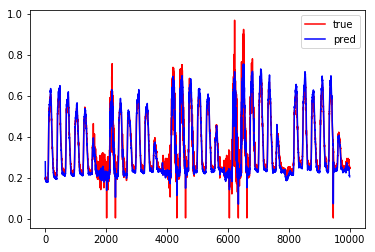

In [30]:
convert_test_x = test_x.reshape(1, 9999, 34)
convert_test_y = test_y.reshape(1, 9999, 1)

h = np.zeros((convert_test_x.shape[0], n_hidden))
c = np.zeros((convert_test_x.shape[0], n_hidden))

result = []
for i in range(convert_test_x.shape[1]):
    var_tmp, h, c = model.forward(convert_test_x[:, i, :], h, c)
    result.append(sigmoid(var_tmp['y']))

prediction_result = np.array(result).flatten()

plt.figure()
plt.plot(test_y.tolist(), color='red', label='true')
plt.plot(prediction_result.tolist(), color='blue', label='pred')
plt.legend()
plt.show()